<a href="https://colab.research.google.com/github/ilsurgumerov/MHD_Rotating_Fluids/blob/main/MHD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install sympy


# Нахождение аналитического представления для МГД характеристик в случае решение в виде гармонической волны

#### Нужные импорты

In [26]:
import sympy as sp
from numbers import Number
import numpy as np

#### Создаем класс для операторов, чтобы с ними было легче работать

In [27]:
class DiffOperator:
    def __init__(self, applicator):
        self.applicator = applicator

    def __add__(self, other):
        # Сложение с другим оператором или скаляром
        if isinstance(other, DiffOperator):
            return DiffOperator(lambda f: self(f) + other(f))
        elif isinstance(other, (Number, sp.Expr)):
            return DiffOperator(lambda f: self(f) + other * f)
        raise TypeError("Unsupported operand type for +")

    def __radd__(self, other):
        # Обратное сложение (скаляр + оператор)
        return self.__add__(other)

    def __sub__(self, other):
        # Вычитание оператора или скаляра
        if isinstance(other, DiffOperator):
            return DiffOperator(lambda f: self(f) - other(f))
        elif isinstance(other, (Number, sp.Expr)):
            return DiffOperator(lambda f: self(f) - other * f)
        raise TypeError("Unsupported operand type for -")

    def __rsub__(self, other):
        # Обратное вычитание (скаляр - оператор)
        return DiffOperator(lambda f: other * f - self(f))

    def __mul__(self, other):
        # Если other — функция: применяем оператор к ней
        if isinstance(other, sp.Expr):
            return self(other)
        # Если other — оператор: композиция
        elif isinstance(other, DiffOperator):
            return DiffOperator(lambda f: self(other(f)))
        # Если other — скаляр: масштабирование
        elif isinstance(other, (Number, sp.Expr)):
            return DiffOperator(lambda f: other * self(f))
        raise TypeError(f"Unsupported operand type: {type(other)}")

    def __rmul__(self, other):
        # Обратное умножение (скаляр * оператор)
        return self.__mul__(other)

    # Добавляем деление на скаляр
    def __truediv__(self, other):
        if isinstance(other, (Number, sp.Expr)):
            return DiffOperator(lambda f: self(f) / other)
        raise TypeError(f"Unsupported operand type: {type(other)}")

    def __pow__(self, n):
        # Возведение оператора в степень (n-кратная композиция)
        if not isinstance(n, int) or n < 0:
            raise ValueError("Power must be a non-negative integer")
        result = DiffOperator(lambda f: f)
        for _ in range(n):
            result = self * result
        return result

    def __call__(self, f):
        # Применение оператора к функции
        return self.applicator(f)

    def __repr__(self):
        return "DiffOperator(...)"

# Объявляем переменные и константы
x, y, t, z = sp.symbols('x y t z')
A, sigma_1, sigma_2, k, l, b_0x, b_0y = sp.symbols('A sigma_1 sigma_2 k l b_{0x} b_{0y}')
alpha, rho, mu, Rm, g = sp.symbols('alpha rho mu Rm g', constant=True)

b_no = sp.Function('b_no')(x, y, t)
h_B = sp.Function('h_B')(x, y, t)

# Z = sp.Function('Z')(x, y)
# H_0 - sp.Function('H_0')(x, y)
H_0 = sp.symbols('H_0')
Z = sp.symbols('Z')

# Определяем операторы
D_ = DiffOperator(lambda f: b_0x * sp.diff(f, x) + b_0y * sp.diff(f, y))
Dt_ = DiffOperator(lambda f: sp.diff(f, t))
delta_ = DiffOperator(lambda f: sp.diff(f, x, x) + sp.diff(f, y, y))

F_ = mu * rho * (Dt_**2 + alpha) * (Dt_ - delta_/Rm) - D_**2 * Dt_

# Определяем функцию ksi(x, y, t)
ksi = sp.Function('ksi')(x, y, t)
ksi = A * sp.exp(sigma_2 * t) * sp.cos(k*x + l*y - sigma_1*t)

#### Если будет нужен не константый P



In [28]:
# # Функции, зависящие от (x, y, z)
# p0 = sp.Function('p0')(x, y, z)
# b0_sq = sp.Function('b0^2')(x, y, z)

# p0_const, b0_sq_const = sp.symbols('p0^const b0^const', constant=True)
# # p0 = p0_const
# b0_sq = b0_sq_const

# # Функция P(x, y, z)
# P = -1 / rho * (p0 + b0_sq / alpha)

# # Определяем Pqq как функцию от t (но позже добавим зависимость от x, y, z)
# Pqq = sp.Function('Pqq')(t)

# # Записываем уравнение
# eq = sp.Eq(sp.diff(Pqq, t, t) + alpha**2 * Pqq, P)

# # Решаем ОДУ
# sol = sp.dsolve(eq, Pqq)

# # Извлекаем общее решение и заменяем C1, C2 на функции от (x, y, z)
# C1, C2 = sp.symbols('C1 C2', function=True)
# C1_func = sp.Function('C1')(x, y, z)
# C2_func = sp.Function('C2')(x, y, z)

# # Подставляем C1 и C2 как функции от (x, y, z)
# general_solution = sol.rhs.subs({sp.Symbol('C1'): C1_func, sp.Symbol('C2'): C2_func})

# # Вывод результата
# # sp.pprint(general_solution)
# Pqq = general_solution
# Pqq = Pqq.subs({C1_func : 0, C2_func : 0})
# Pqq

#### Аналитическое представление для $b_x, b_y$ через $\xi$

In [29]:
bxyTwoMatrixOperator_ = np.array([[D_ * (Dt_ ** 2 + alpha ** 2) * (mu * rho * Dt_ * (Dt_ - delta_ / Rm) - D_ ** 2), D_ * (Dt_ ** 2 + alpha ** 2) * alpha * mu * rho * (Dt_ - delta_ / Rm)],
                                  [D_ * (Dt_ ** 2 + alpha ** 2) * (-alpha * mu * rho * (Dt_ - delta_ / Rm)), D_ * (Dt_ ** 2 + alpha ** 2) * (mu * rho * Dt_ * (Dt_ - delta_ / Rm) - D_ ** 2)]])


bxTwo, byTwo = bxyTwoMatrixOperator_ @ np.array([sp.diff(ksi, x), sp.diff(ksi, y)])

bx = sp.Function('bx')(x, y, t)
by = sp.Function('by')(x, y, t)

bx, by = mu * rho * (Dt_ ** 2 + alpha ** 2) * np.array([bxTwo, byTwo]).T

bx_collect = sp.collect(sp.expand(bx), [sp.exp(sigma_2 * t) * sp.cos(k * x + l * y - sigma_1 * t), sp.exp(sigma_2 * t) * sp.sin(k * x + l * y - sigma_1 * t)])
bx_final = bx_collect.replace(lambda expr: isinstance(expr, sp.Mul), lambda expr: sp.factor(expr))

by_collect = sp.collect(sp.expand(by), [sp.exp(sigma_2 * t) * sp.cos(k * x + l * y - sigma_1 * t), sp.exp(sigma_2 * t) * sp.sin(k * x + l * y - sigma_1 * t)])
by_final = by_collect.replace(lambda expr: isinstance(expr, sp.Mul), lambda expr: sp.factor(expr))

bx_final
# bx.subs({k : 1, l : 2, b_0x : 0, b_0y : 1})

-2*A*alpha**2*k*mu*rho*sigma_1*sigma_2*(b_{0x}*k + b_{0y}*l)**3*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t) - A*alpha**2*k*mu*rho*(b_{0x}*k + b_{0y}*l)**3*(alpha**2 - sigma_1**2 + sigma_2**2)*exp(sigma_2*t)*cos(k*x + l*y - sigma_1*t)

In [30]:
by_final

-2*A*alpha**2*l*mu*rho*sigma_1*sigma_2*(b_{0x}*k + b_{0y}*l)**3*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t) - A*alpha**2*l*mu*rho*(b_{0x}*k + b_{0y}*l)**3*(alpha**2 - sigma_1**2 + sigma_2**2)*exp(sigma_2*t)*cos(k*x + l*y - sigma_1*t)

#### ЭКСПЕРИМЕНТЫ

In [31]:
# bxyTwoMatrixOperator_ = np.array([[D_ * (Dt_ ** 2 + alpha ** 2) * (mu * ro * Dt_ * (Dt_ - delta_ / Rm) - D_ ** 2), D_ * (Dt_ ** 2 + alpha ** 2) * alpha * mu * ro * (Dt_ - delta_ / Rm)],
#                                   [D_ * (Dt_ ** 2 + alpha ** 2) * (-alpha * mu * ro * (Dt_ - delta_ / Rm)), D_ * (Dt_ ** 2 + alpha ** 2) * (mu * ro * Dt_ * (Dt_ - delta_ / Rm) - D_ ** 2)]])

# bxTwo, byTwo = bxyTwoMatrixOperator_ @ np.array([sp.diff(ksi, x) + sp.diff(Pqq, x), sp.diff(ksi, y) + sp.diff(Pqq, y)])

# bx, by = mu * ro * (Dt_ ** 2 + alpha ** 2) * np.array([bxTwo, byTwo]).T

# bx_collect = sp.collect(sp.expand(bx), [sp.exp(sigma_2 * t) * sp.cos(k * x + l * y - sigma_1 * t), sp.exp(sigma_2 * t) * sp.sin(k * x + l * y - sigma_1 * t)], evaluate=False)
# bx_final = bx_collect.replace(lambda expr: isinstance(expr, sp.Mul), lambda expr: sp.factor(expr))

# by_collect = sp.collect(sp.expand(by), [sp.exp(sigma_2 * t) * sp.cos(k * x + l * y - sigma_1 * t), sp.exp(sigma_2 * t) * sp.sin(k * x + l * y - sigma_1 * t)], evaluate=False)
# by_final = by_collect.replace(lambda expr: isinstance(expr, sp.Mul), lambda expr: sp.factor(expr))

# bx_final
# # bx.subs({k : 1, l : 2, b_0x : 0, b_0y : 1})

#### Аналитическое представление для $\eta$, $\eta_{Two}$ через $\xi$

In [32]:
nuTwo = sp.Function('nuTwo')(x, y, t)
nuTwo = (F_ ** 2 + (alpha * D_ ** 2) ** 2) * ksi

nuTwo_collect = sp.collect(sp.expand(nuTwo), [sp.exp(sigma_2 * t) * sp.cos(k * x + l * y - sigma_1 * t), sp.exp(sigma_2 * t) * sp.sin(k * x + l * y - sigma_1 * t)])
nuTwo_final = nuTwo_collect.replace(lambda expr: isinstance(expr, sp.Mul), lambda expr: sp.factor(expr))
nuTwo_final
# nuTwo.subs({k : 1, l : 1, b_0x : 0, b_0y : 1})

2*A*sigma_1*sigma_2*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t) - A*(sigma_1 - sigma_2)*(sigma_1 + sigma_2)*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*cos(k*x + l*y - sigma_1*t)

In [33]:
nu = sp.Function('nu')(x, y, t)
nu = -1 / g * (Dt_ ** 2 + alpha ** 2) * nuTwo

nu_collect = sp.collect(sp.expand(nu), [sp.exp(sigma_2 * t) * sp.cos(k * x + l * y - sigma_1 * t), sp.exp(sigma_2 * t) * sp.sin(k * x + l * y - sigma_1 * t)])
nu_final = nu_collect.replace(lambda expr: isinstance(expr, sp.Mul), lambda expr: sp.factor(expr))
nu_final
# nu.subs({k : 1, l : 1, b_0x : 0, b_0y : 1})

-2*A*alpha**2*sigma_1*sigma_2*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t)/g + A*alpha**2*(sigma_1 - sigma_2)*(sigma_1 + sigma_2)*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*cos(k*x + l*y - sigma_1*t)/g

#### Аналитическое представление для $v_x, v_y$ через $
\xi$

In [34]:
vx = sp.Function('vx')(x, y, t)
vy = sp.Function('vy')(x, y, t)

vxyMatrixOperator_ = np.array([[Dt_, alpha], [-alpha, Dt_]])

vx, vy = vxyMatrixOperator_ @ np.array([sp.diff(nuTwo, x) + D_ * bxTwo, sp.diff(nuTwo, y) + D_ * byTwo])

vx_collect = sp.collect(sp.expand(vx), [sp.exp(sigma_2 * t) * sp.cos(k * x + l * y - sigma_1 * t), sp.exp(sigma_2 * t) * sp.sin(k * x + l * y - sigma_1 * t)])
vx_final = vx_collect.replace(lambda expr: isinstance(expr, sp.Mul), lambda expr: sp.factor(expr))

vy_collect = sp.collect(sp.expand(vy), [sp.exp(sigma_2 * t) * sp.cos(k * x + l * y - sigma_1 * t), sp.exp(sigma_2 * t) * sp.sin(k * x + l * y - sigma_1 * t)])
vy_final = vy_collect.replace(lambda expr: isinstance(expr, sp.Mul), lambda expr: sp.factor(expr))

vx_final
# vx.subs({k : 1, l : 1, b_0x : 0, b_0y : 1})

-A*alpha**2*k*sigma_1*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*cos(k*x + l*y - sigma_1*t) + A*alpha**2*(alpha*l + k*sigma_2)*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t)

In [35]:
vy_final
# vy.subs({k : 1, l : 1, b_0x : 0, b_0y : 1})

-A*alpha**2*l*sigma_1*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*cos(k*x + l*y - sigma_1*t) - A*alpha**2*(alpha*k - l*sigma_2)*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t)

#### Аналитическое представление для $b_z$ через $\xi$

In [36]:
bz = sp.Function('bz')(x, y, z, t)

h_B = H_0 + Z + nu

bz = - (h_B + z) * (sp.diff(bx, x) + sp.diff(by, y)) - bx * sp.diff(h_B, x) - by * sp.diff(h_B, y) + b_no

bz_collect = sp.collect(sp.expand(bz), [sp.exp(sigma_2 * t) * sp.cos(k * x + l * y - sigma_1 * t), sp.exp(sigma_2 * t) * sp.sin(k * x + l * y - sigma_1 * t)])
bz_final = bz_collect.replace(lambda expr: isinstance(expr, sp.Mul), lambda expr: sp.factor(expr))
bz_final
# bz.subs({k : 1, l : 1, b_0x : 0, b_0y : 1})

2*A**2*alpha**4*mu*rho*sigma_1*sigma_2*(k**2 + l**2)*(b_{0x}*k + b_{0y}*l)**7*(alpha**2 - 2*sigma_1**2 + 2*sigma_2**2)*exp(2*sigma_2*t)*sin(k*x + l*y - sigma_1*t)**2/g - 2*A**2*alpha**4*mu*rho*sigma_1*sigma_2*(k**2 + l**2)*(b_{0x}*k + b_{0y}*l)**7*(alpha**2 - 2*sigma_1**2 + 2*sigma_2**2)*exp(2*sigma_2*t)*cos(k*x + l*y - sigma_1*t)**2/g - A*alpha**2*mu*rho*(k**2 + l**2)*(b_{0x}*k + b_{0y}*l)**3*(H_0 + Z + z)*(alpha**2 - sigma_1**2 + sigma_2**2)*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t) + 2*A*alpha**2*mu*rho*(k**2 + l**2)*(b_{0x}*k + b_{0y}*l)**3*(-A*alpha**4*b_{0x}**4*k**4*sigma_1**2*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t) + A*alpha**4*b_{0x}**4*k**4*sigma_2**2*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t) - 4*A*alpha**4*b_{0x}**3*b_{0y}*k**3*l*sigma_1**2*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t) + 4*A*alpha**4*b_{0x}**3*b_{0y}*k**3*l*sigma_2**2*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t) - 6*A*alpha**4*b_{0x}**2*b_{0y}**2*k**2*l**2*sigma_1**2*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t) + 6*A

#### Аналитическое представление для $v_z$ через $\xi$

In [37]:
vz = sp.Function('vz')(x, y, z, t)

vz = (1 / H_0 * Dt_ * nu + sp.ln(H_0) * (sp.diff(vx, x) + sp.diff(vy, y))) * (z + Z) - vx * sp.diff(Z, x) - vy * sp.diff(Z, y)

vz_collect = sp.collect(sp.expand(vz), [sp.exp(sigma_2 * t) * sp.cos(k * x + l * y - sigma_1 * t), sp.exp(sigma_2 * t) * sp.sin(k * x + l * y - sigma_1 * t)])
vz_final = vz_collect.replace(lambda expr: isinstance(expr, sp.Mul), lambda expr: sp.factor(expr))

vz_final
# vz.subs({k : 1, l : 1, b_0x : 0, b_0y : 1})

A*alpha**2*sigma_1*(Z + z)*(k**2 + l**2)*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*log(H_0)*sin(k*x + l*y - sigma_1*t) + A*alpha**2*sigma_2*(Z + z)*(k**2 + l**2)*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*log(H_0)*cos(k*x + l*y - sigma_1*t)

In [38]:
H_0 = sp.symbols('H_0')
Z = sp.symbols('Z')
# Z = sp.Function('Z')(x, y)

# vz = (1 / H_0 * Dt_ * nu + sp.ln(H_0) * (sp.diff(vx, x) + sp.diff(vy, y))) * (z + Z) - vx * sp.diff(Z, x) - vy * sp.diff(Z, y)
vz = -(Z + z) * (sp.diff(vx, x) + sp.diff(vy, y)) - vx * sp.diff(Z, x) - vy * sp.diff(Z, y)

vz_collect = sp.collect(sp.expand(vz), [sp.exp(sigma_2 * t) * sp.cos(k * x + l * y - sigma_1 * t), sp.exp(sigma_2 * t) * sp.sin(k * x + l * y - sigma_1 * t)])
vz_final = vz_collect.replace(lambda expr: isinstance(expr, sp.Mul), lambda expr: sp.factor(expr))

vz_final
# vz.subs({k : 1, l : 1, b_0x : 0, b_0y : 1})

-A*alpha**2*sigma_1*(Z + z)*(k**2 + l**2)*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t) - A*alpha**2*sigma_2*(Z + z)*(k**2 + l**2)*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*cos(k*x + l*y - sigma_1*t)

#### Отрисовка 3д графика $\eta$

In [17]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [18]:
nu_final

-2*A*alpha**2*sigma_1*sigma_2*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*sin(k*x + l*y - sigma_1*t)/g + A*alpha**2*(sigma_1 - sigma_2)*(sigma_1 + sigma_2)*(b_{0x}*k + b_{0y}*l)**4*exp(sigma_2*t)*cos(k*x + l*y - sigma_1*t)/g

In [19]:
# Пример значений (замените на ваши)
params = {
    A: 1,
    k: 1,          # Волновое число по x
    l: 1,          # Волновое число по y
    sigma_1: 1.,    # Частота
    sigma_2: -1,   # Параметр затухания
    alpha: 1,      # Параметр Кориолиса
    g: 9.8,          # Ускорение свободного падения
    b_0x: 1,
    b_0y: 1
}

nu_final_sub = nu_final.subs(params)

t0 = 100  # Укажите нужный момент времени
nu_final_t0 = nu_final_sub.subs(t, t0)

nu_func = sp.lambdify((x, y), nu_final_t0, 'numpy')
x_vals = np.linspace(-10, 10, 100)  # Диапазон по x
y_vals = np.linspace(-10, 10, 100)  # Диапазон по y
X, Y = np.meshgrid(x_vals, y_vals)
Z = nu_func(X, Y)

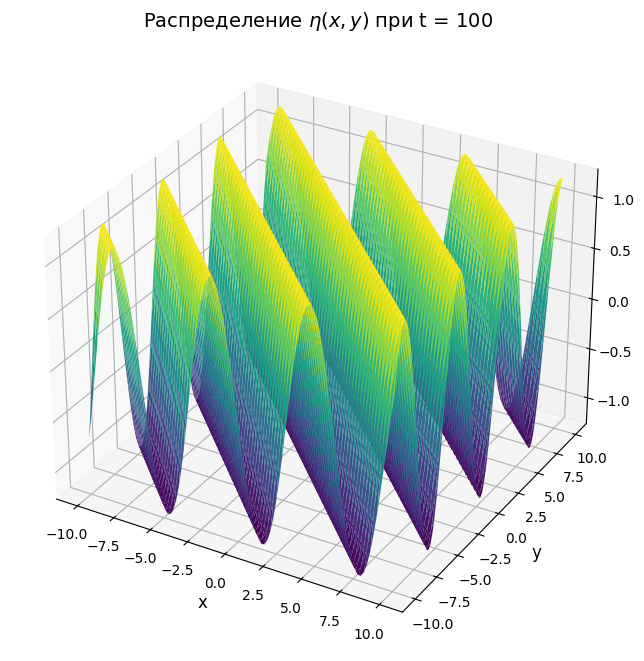

In [20]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Настройки графика
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
# ax.set_zlabel('nu(x, y)', fontsize=12)
ax.set_title(f'Распределение $\eta(x, y)$ при t = {t0}', fontsize=14)
plt.show()

#### Для $b_x, b_y$ силовые линии

In [53]:
# import numpy as np
# import matplotlib.pyplot as plt
# import sympy as sp

# # Определение символов
# x, y, t = sp.symbols('x y t', real=True)

# # Определение экспоненциальных и синусоидальных множителей
# # sigma_1, sigma_2 = sp.symbols('sigma_1 sigma_2', real=True)
# # b_0x = 1
# # b_0y = 1
# # k = 1
# # l = 1
# # exp_factor = sp.exp(sigma_2 * t)
# # wave_factor_cos = sp.cos(k * x + l * y - sigma_1 * t)
# # wave_factor_sin = sp.sin(k * x + l * y - sigma_1 * t)

# bx_expr = bx.subs({b_0x: 1, b_0y: 0, sigma_1: 1, sigma_2: 0, alpha: 1, mu: 1, rho: 1, A: 1, k: 2, l: 1})
# by_expr = by.subs({b_0x: 1, b_0y: 0, sigma_1: 1, sigma_2: 0, alpha: 1, mu: 1, rho: 1, A: 1, k: 2, l: 1})


# # Функции для численного вычисления
# bx_func = sp.lambdify((x, y, t), bx_expr, "numpy")
# by_func = sp.lambdify((x, y, t), by_expr, "numpy")

# # Сетка для построения графика
# x_vals = np.linspace(-5, 5, 20)
# y_vals = np.linspace(-5, 5, 20)
# X, Y = np.meshgrid(x_vals, y_vals)

# # Временные моменты
# time_points = [0, 0.5, 1, 1.5]

# # Построение графиков
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# fig.suptitle("Силовые линии вектора $\\mathbf{b}(x, y, t)$")

# for i, t_val in enumerate(time_points):
#     ax = axes[i // 2, i % 2]
#     bx_vals = bx_func(X, Y, t_val)
#     by_vals = by_func(X, Y, t_val)

#     ax.streamplot(X, Y, bx_vals, by_vals, color="c", density=0.8)
#     ax.set_title(f"t = {t_val}")
#     ax.set_xlim(-2, 2)
#     ax.set_ylim(-2, 2)
#     ax.set_xlabel("$x$")
#     ax.set_ylabel("$y$")

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

In [ ]:
bx_expr

32*exp(-t)*sin(-t + 2*x + y) - 16*exp(-t)*cos(-t + 2*x + y)

In [ ]:
by_expr

16*exp(-t)*sin(-t + 2*x + y) - 8*exp(-t)*cos(-t + 2*x + y)

In [ ]:

for i, t_val in enumerate(time_points):
    ax = axes[i // 2, i % 2]
    bx_vals = bx_func(X, Y, t_val)
    by_vals = by_func(X, Y, t_val)

    ax.streamplot(X, Y, bx_vals, by_vals, color="b", density=1.2)
    ax.set_title(f"t = {t_val}")
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<Figure size 640x480 with 0 Axes>

# Нахождение корней диспирсионного соотношения и отрисовка их на графиках

#### Нужные импорты

In [40]:
import mpmath
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import subprocess

#### Компиляция c++ файла

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!g++ /content/drive/MyDrive/Colab\ Notebooks/newton.cpp -o newton

#### Функция для работы с c++ файлом

In [43]:
def get_roots(rm, coefficients):
    # Формируем строку для передачи в C++ (Rm и коэффициенты)
    input_data = f"{rm}\n" + "\n".join(f"{c.real} {c.imag}" for c in coefficients) + "\n"

    # Запускаем C++ программу через subprocess
    result = subprocess.run(
        ["./newton"], input=input_data, text=True, capture_output=True
    )

    # Обрабатываем выходные данные
    output = result.stdout.strip().split("\n")

    if len(output[0]) == 0:
        return -1, []

    rm_out = float(output[0])
    roots = [complex(*map(float, line.split())) for line in output[1:]]

    return rm_out, roots

#### Диспирсионное уравнение и поиск его корней

In [44]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

sigma, k, l, b_0x, b_0y, alpha, Rm, H_0, mu, rho, g, A, B = sp.symbols("sigma k l b_0x b_0y alpha Rm H_0 mu rho g A B")

expr = (-(b_0x * k + b_0y * l) * (sigma ** 2 - alpha ** 2) ** 2 * (-(sigma ** 2) - sp.I * sigma * (k ** 2 + l ** 2) / Rm + (b_0x * k + b_0y * l) ** 2 / (mu * rho)) * (k ** 2 + l ** 2)
        + 1 / (g * (mu * rho) ** 2 * H_0) * (alpha ** 2 - sigma ** 2) *
            (
                (mu * rho) ** 2 * (sigma ** 2 - alpha ** 2) ** 2 * (-sp.I * sigma + (k ** 2 + l ** 2) / Rm) ** 2
                - (b_0x * k + b_0y * l) ** 4 * (sigma ** 2 - alpha ** 2)
                + 2 * mu * sp.I * rho * sigma * (alpha ** 2 - sigma ** 2) * (-sp.I * sigma + (k ** 2 + l ** 2) / Rm) * (b_0x * k + b_0y * l) ** 2
            ) * (b_0x * k + b_0y * l)
        + B * sp.I / (A * (mu * rho) ** 2 * H_0)
       )
# expr = (k * b_0x + l * b_0y) * (k ** 2 + l ** 2) * (alpha ** 2 - sigma ** 2) ** 2 * (sigma ** 2 + sigma * (sp.I * (l ** 2 + k ** 2) / Rm) + ((k * b_0x + l * b_0y) ** 2) / (mu * ro)) - B / (H_0 * (mu * ro) ** 2)

# expanded_expr = sp.expand(expr)
# collected_expr = sp.collect(expanded_expr, sigma)

collected_expr = expr
# Фиксированные параметры
parameter_values = {
    k: 1,
    l: 1,
    b_0x: 1,
    b_0y: 1,
    mu: 1,
    rho: 1,
    Rm: 0.1,
    alpha: 1,
    g: 9.8,
    H_0: 1,
    A: 1,
    B: 0
}

params_to_vary = [k, Rm, alpha, B]
param_values = np.linspace(0, 20, 100)

all_results = {}

# Вычисление корней через C++
for param in params_to_vary:
    results = []
    for val in param_values:
        param_dict = parameter_values.copy()
        param_dict[param] = val
        numeric_expr = collected_expr.subs(param_dict)
        poly = sp.Poly(numeric_expr, sigma)
        coeffs = [complex(s) for s in poly.all_coeffs()]
        param_out, roots = get_roots(val, coeffs)
        results.append((param_out, roots))
    all_results[param] = results

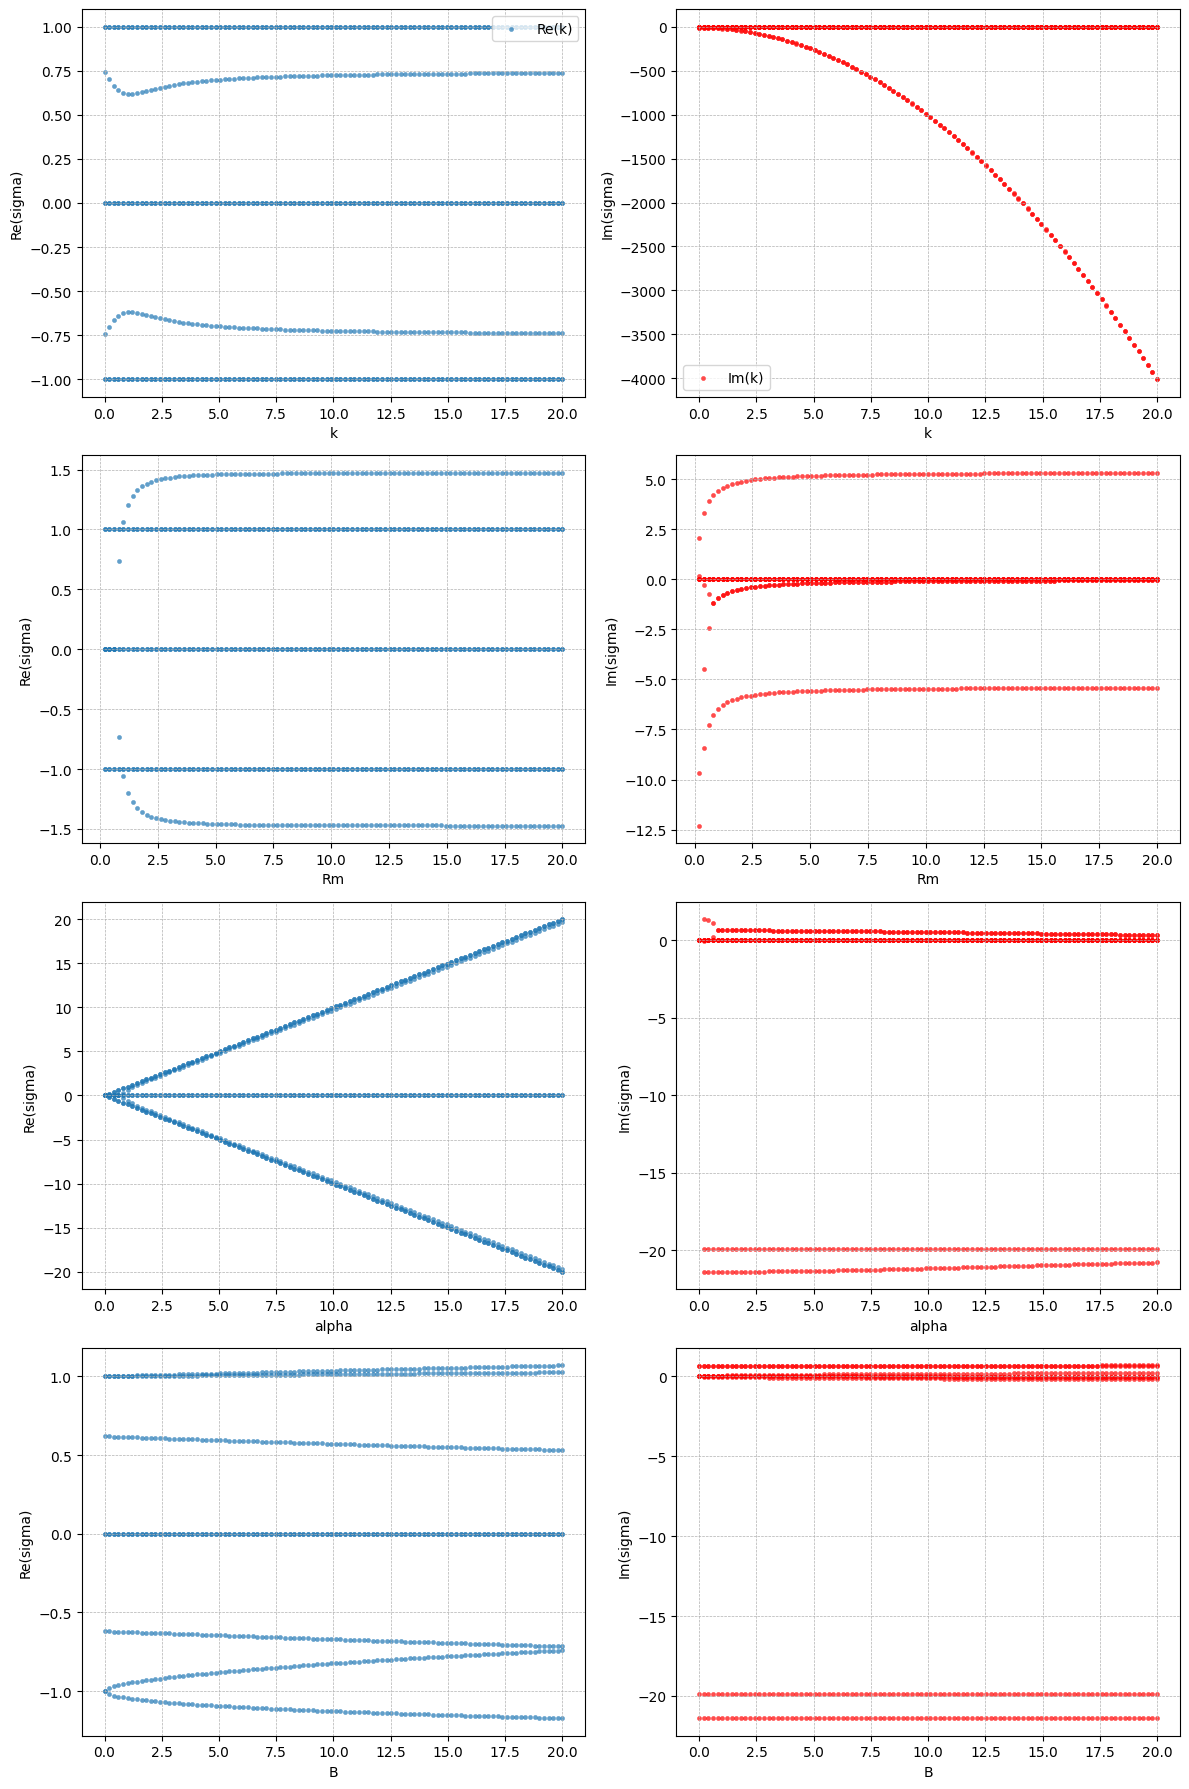

In [45]:
# Визуализация
fig, axes = plt.subplots(len(params_to_vary), 2, figsize=(12, 18))

for i, param in enumerate(params_to_vary):
    param_results = all_results[param]
    param_vals, re_vals, im_vals = [], [], []
    for val, roots in param_results:
        param_vals.extend([val for _ in roots])
        re_vals.extend([root.real for root in roots])
        im_vals.extend([root.imag for root in roots])

    axes[i, 0].scatter(param_vals, re_vals, s=10, alpha=0.7, linewidth=0.2, label=f'Re({param})')
    axes[i, 0].set_xlabel(str(param))
    axes[i, 0].set_ylabel("Re(sigma)")
    axes[i, 0].grid(True, linestyle="--", linewidth=0.5)

    axes[i, 1].scatter(param_vals, im_vals, s=10, alpha=0.7, linewidth=0.2, label=f'Im({param})', color='red')
    axes[i, 1].set_xlabel(str(param))
    axes[i, 1].set_ylabel("Im(sigma)")
    axes[i, 1].grid(True, linestyle="--", linewidth=0.5)

axes[0, 0].legend()
axes[0, 1].legend()
plt.tight_layout()
plt.show()

#### Результаты для неоднородного случая B != 0

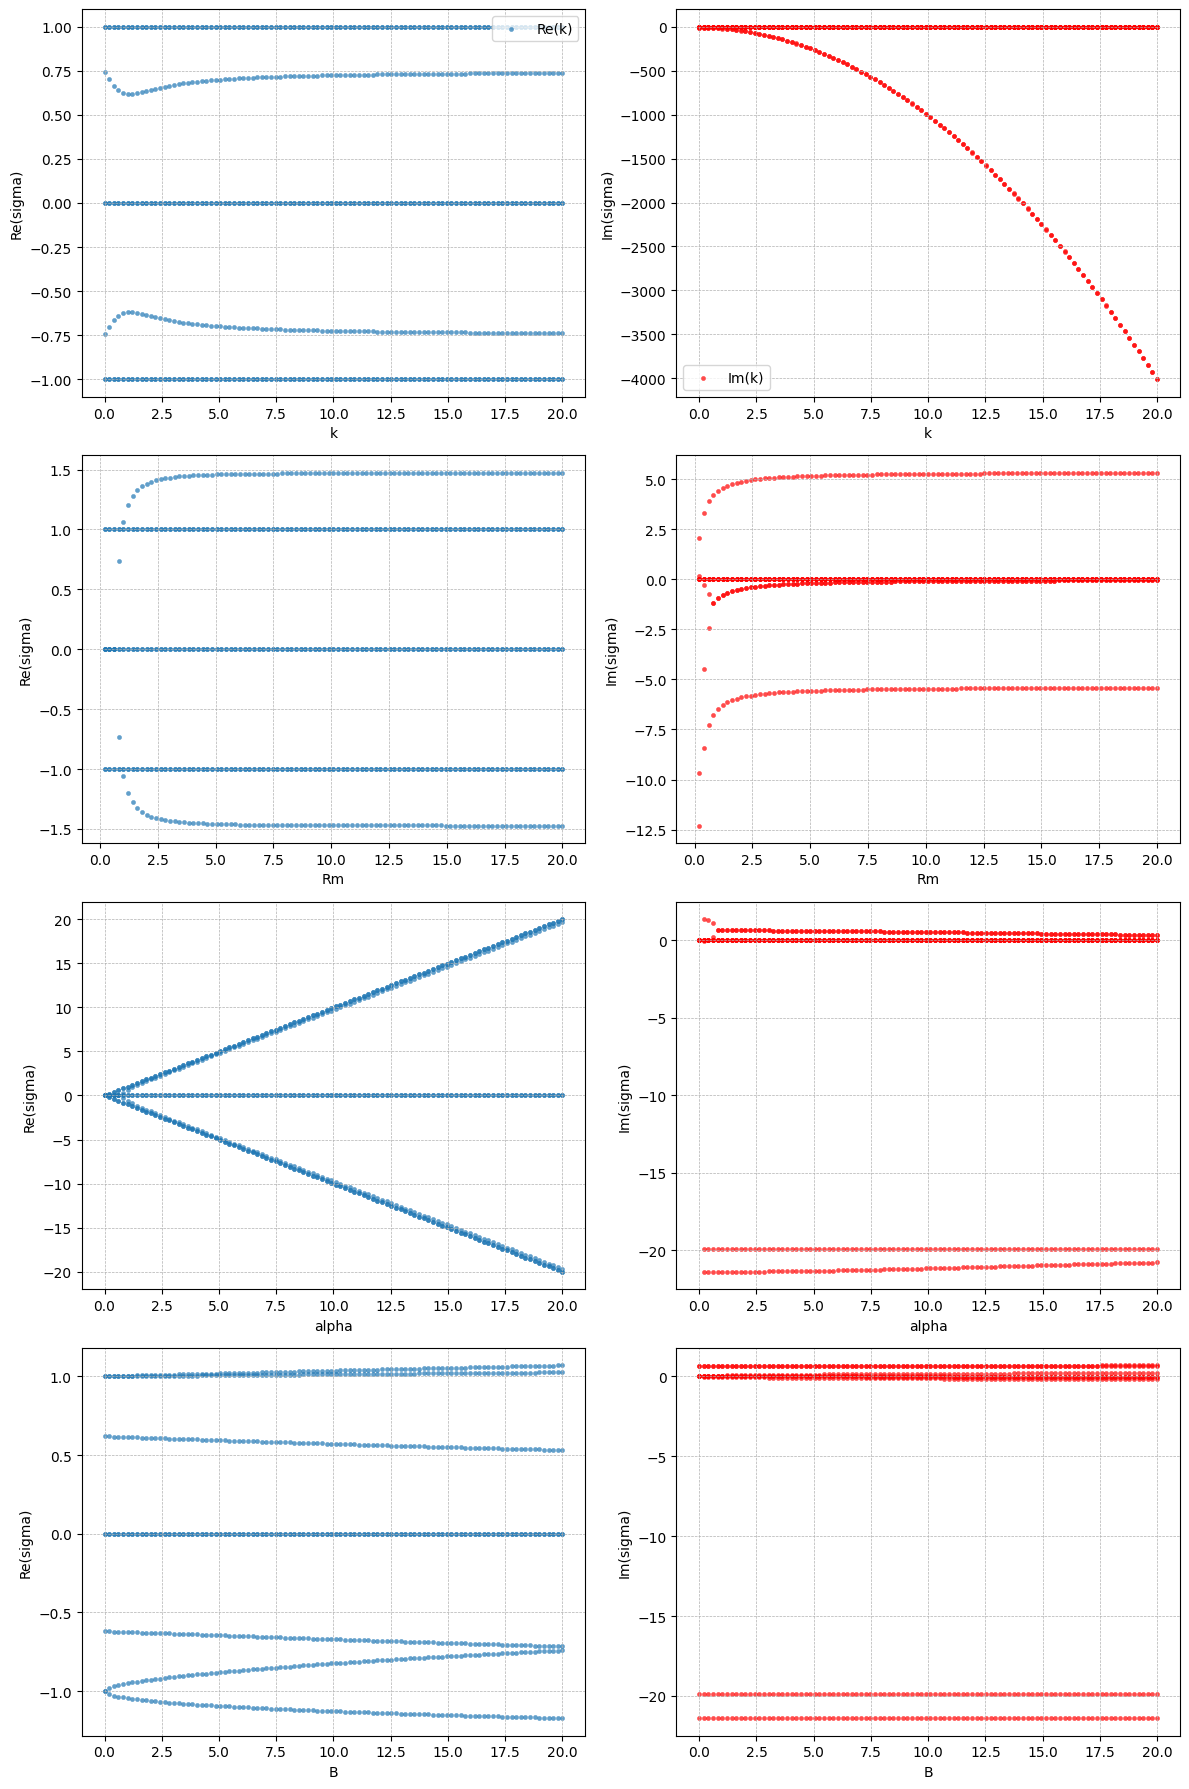

In [46]:
# Визуализация
fig, axes = plt.subplots(len(params_to_vary), 2, figsize=(12, 18))

for i, param in enumerate(params_to_vary):
    param_results = all_results[param]
    param_vals, re_vals, im_vals = [], [], []
    for val, roots in param_results:
        param_vals.extend([val for _ in roots])
        re_vals.extend([root.real for root in roots])
        im_vals.extend([root.imag for root in roots])

    axes[i, 0].scatter(param_vals, re_vals, s=10, alpha=0.7, linewidth=0.2, label=f'Re({param})')
    axes[i, 0].set_xlabel(str(param))
    axes[i, 0].set_ylabel("Re(sigma)")
    axes[i, 0].grid(True, linestyle="--", linewidth=0.5)

    axes[i, 1].scatter(param_vals, im_vals, s=10, alpha=0.7, linewidth=0.2, label=f'Im({param})', color='red')
    axes[i, 1].set_xlabel(str(param))
    axes[i, 1].set_ylabel("Im(sigma)")
    axes[i, 1].grid(True, linestyle="--", linewidth=0.5)

axes[0, 0].legend()
axes[0, 1].legend()
plt.tight_layout()
plt.show()

#### Результаты для однородного случая B = 0

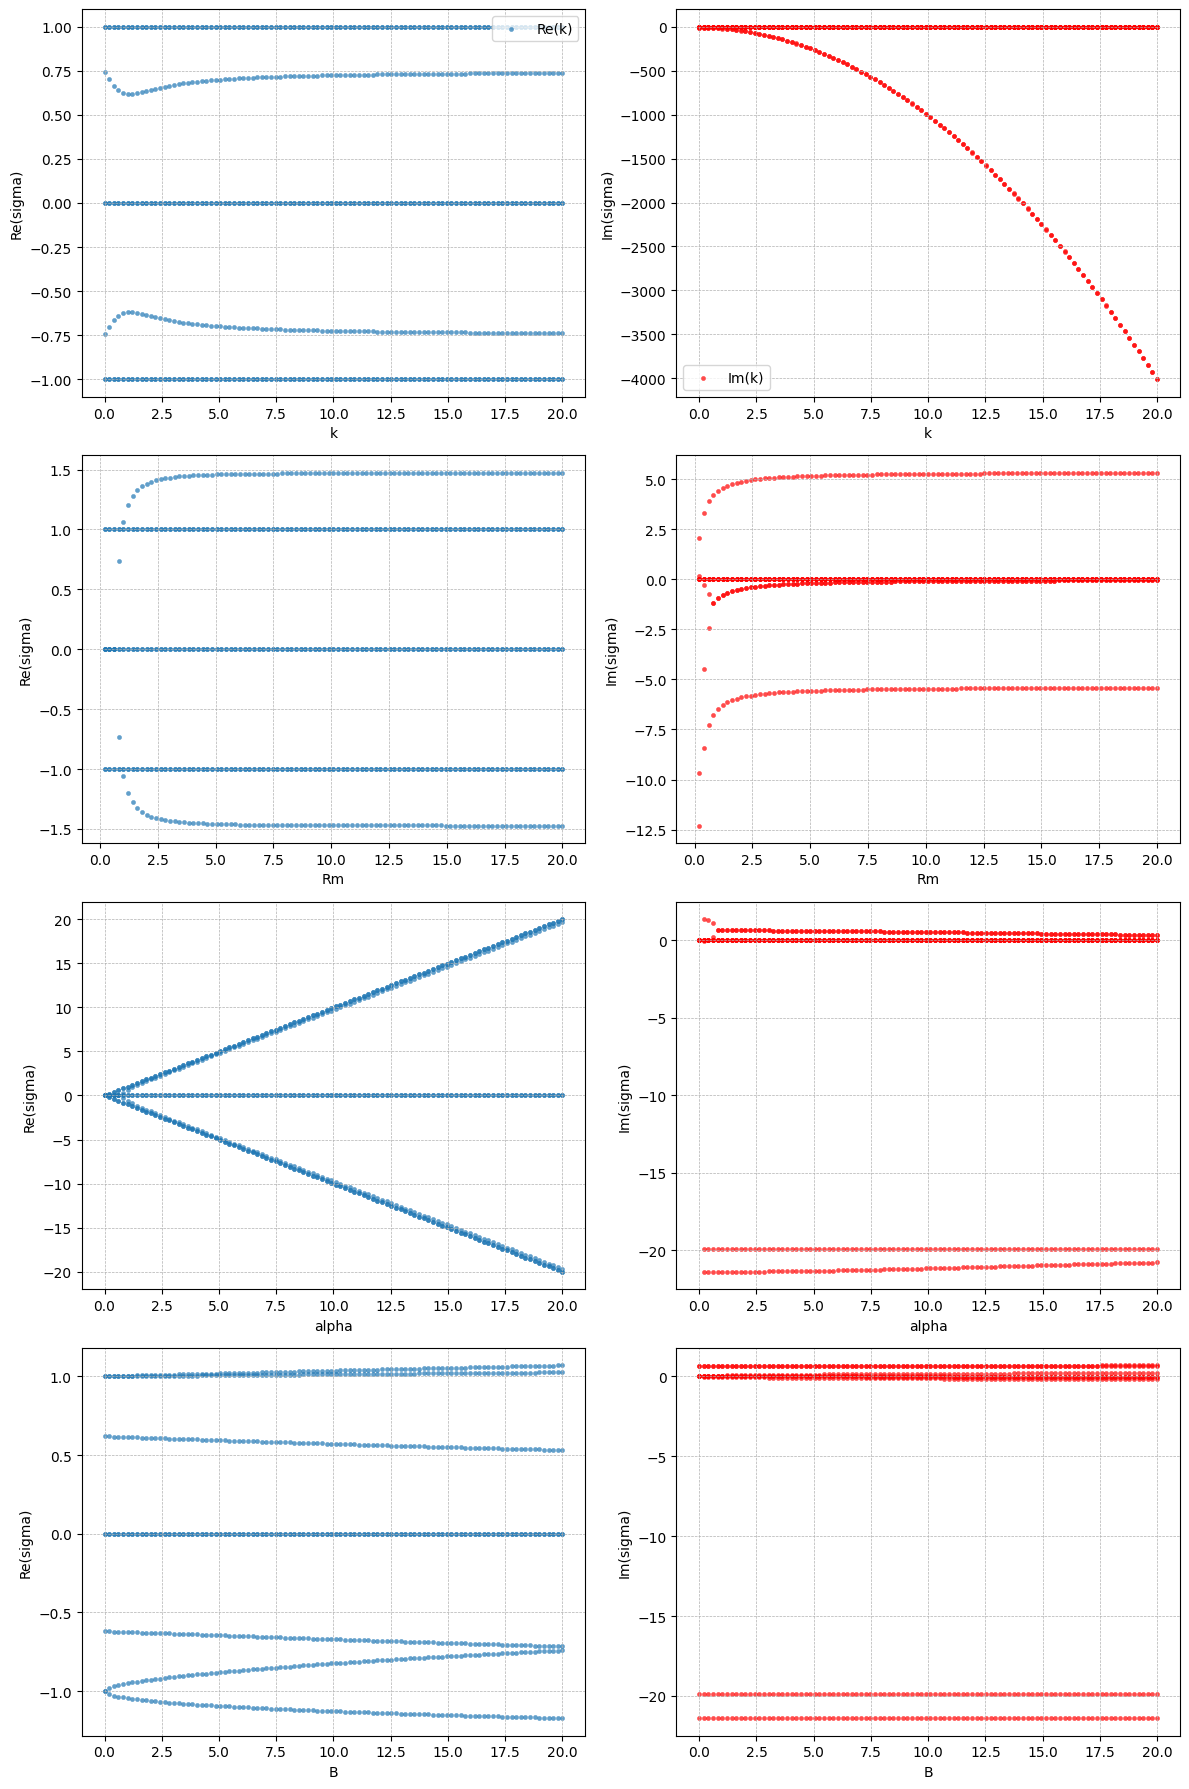

In [47]:
# Визуализация
fig, axes = plt.subplots(len(params_to_vary), 2, figsize=(12, 18))

for i, param in enumerate(params_to_vary):
    param_results = all_results[param]
    param_vals, re_vals, im_vals = [], [], []
    for val, roots in param_results:
        param_vals.extend([val for _ in roots])
        re_vals.extend([root.real for root in roots])
        im_vals.extend([root.imag for root in roots])

    axes[i, 0].scatter(param_vals, re_vals, s=10, alpha=0.7, linewidth=0.2, label=f'Re({param})')
    axes[i, 0].set_xlabel(str(param))
    axes[i, 0].set_ylabel("Re(sigma)")
    axes[i, 0].grid(True, linestyle="--", linewidth=0.5)

    axes[i, 1].scatter(param_vals, im_vals, s=10, alpha=0.7, linewidth=0.2, label=f'Im({param})', color='red')
    axes[i, 1].set_xlabel(str(param))
    axes[i, 1].set_ylabel("Im(sigma)")
    axes[i, 1].grid(True, linestyle="--", linewidth=0.5)

axes[0, 0].legend()
axes[0, 1].legend()
plt.tight_layout()
plt.show()

# Отрисовка для статьи

In [48]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

sigma, k, l, b_0x, b_0y, alpha, Rm, H_0, mu, rho, g, A, B = sp.symbols("sigma k l b_0x b_0y alpha Rm H_0 mu rho g A B")

expr = (-(b_0x * k + b_0y * l) * (sigma ** 2 - alpha ** 2) ** 2 * (-(sigma ** 2) - sp.I * sigma * (k ** 2 + l ** 2) / Rm + (b_0x * k + b_0y * l) ** 2 / (mu * rho)) * (k ** 2 + l ** 2)
        + 1 / (g * (mu * rho) ** 2 * H_0) * (alpha ** 2 - sigma ** 2) *
            (
                (mu * rho) ** 2 * (sigma ** 2 - alpha ** 2) ** 2 * (-sp.I * sigma + (k ** 2 + l ** 2) / Rm) ** 2
                - (b_0x * k + b_0y * l) ** 4 * (sigma ** 2 - alpha ** 2)
                + 2 * mu * sp.I * rho * sigma * (alpha ** 2 - sigma ** 2) * (-sp.I * sigma + (k ** 2 + l ** 2) / Rm) * (b_0x * k + b_0y * l) ** 2
            ) * (b_0x * k + b_0y * l)
        + B * sp.I / (A * (mu * rho) ** 2 * H_0)
       )

collected_expr = expr

# for B != 0
parameter_values = {
    k: 1,
    l: 1,
    b_0x: 1,
    b_0y: 1,
    mu: 1,
    rho: 1,
    Rm: 100,
    alpha: 1,
    g: 9.8,
    H_0: 1,
    A: 1,
    B: 100
}

params_to_vary = [k, Rm, alpha, B]
param_values = np.linspace(0, 1000, 200)

all_results_with_B = {}
all_results_without_B = {}

for param in params_to_vary:
    results = []
    for val in param_values:
        param_dict = parameter_values.copy()
        param_dict[param] = val
        numeric_expr = collected_expr.subs(param_dict)
        poly = sp.Poly(numeric_expr, sigma)
        coeffs = [complex(s) for s in poly.all_coeffs()]
        param_out, roots = get_roots(val, coeffs)
        results.append((param_out, roots))
    all_results_with_B[param] = results

# for B = 0
parameter_values = {
    k: 1,
    l: 1,
    b_0x: 1,
    b_0y: 1,
    mu: 1,
    rho: 1,
    Rm: 100,
    alpha: 1,
    g: 9.8,
    H_0: 1,
    A: 1,
    B: 0
}

for param in params_to_vary:
    results = []
    for val in param_values:
        param_dict = parameter_values.copy()
        param_dict[param] = val
        numeric_expr = collected_expr.subs(param_dict)
        poly = sp.Poly(numeric_expr, sigma)
        coeffs = [complex(s) for s in poly.all_coeffs()]
        param_out, roots = get_roots(val, coeffs)
        results.append((param_out, roots))
    all_results_without_B[param] = results

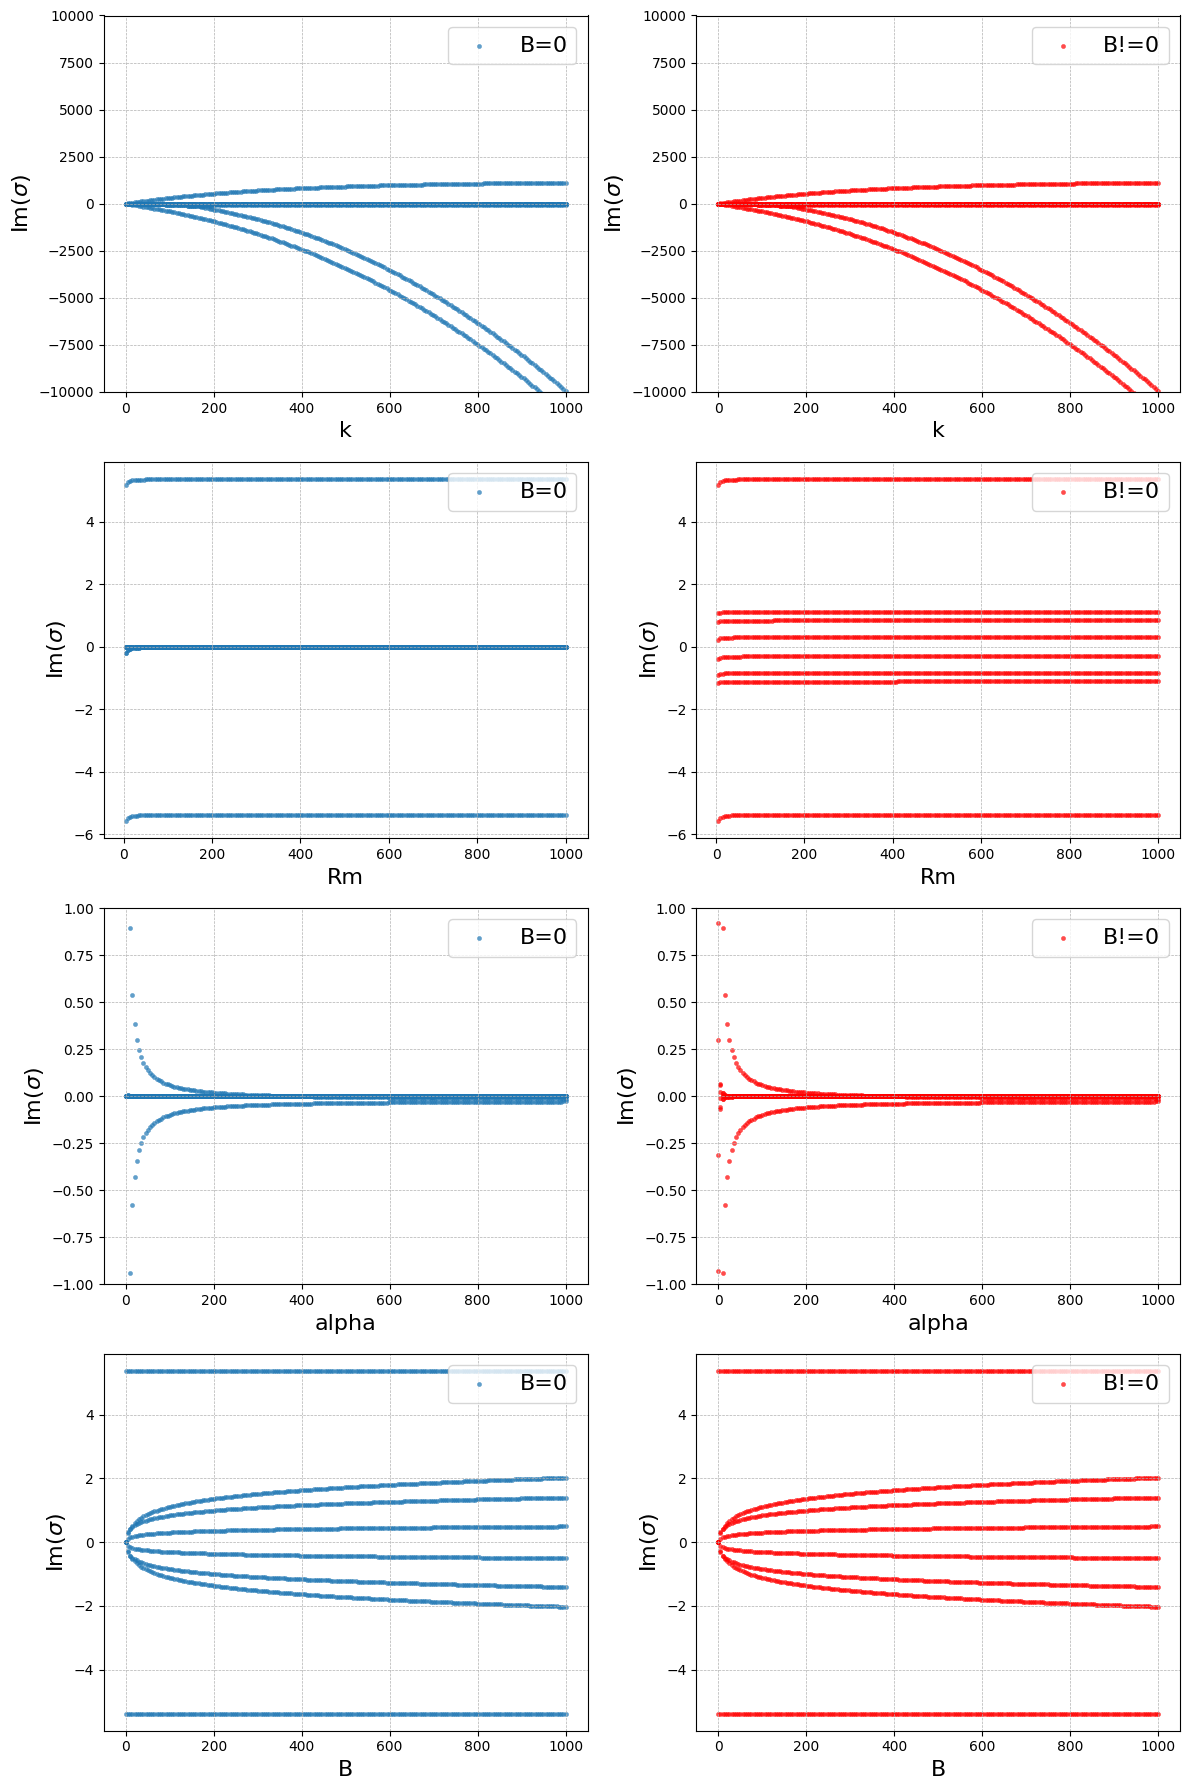

In [50]:
# Визуализация
fig, axes = plt.subplots(len(params_to_vary), 2, figsize=(12, 18))

for i, param in enumerate(params_to_vary):
    param_results_with_B = all_results_with_B[param]
    param_results_without_b = all_results_without_B[param]

    param_vals_with_B, re_vals_with_B, im_vals_with_B = [], [], []
    for val, roots in param_results_with_B:
        param_vals_with_B.extend([val for _ in roots])
        re_vals_with_B.extend([root.real for root in roots])
        im_vals_with_B.extend([root.imag for root in roots])

    param_vals_without_B, re_vals_without_B, im_vals_without_B = [], [], []
    for val, roots in param_results_without_b:
        param_vals_without_B.extend([val for _ in roots])
        re_vals_without_B.extend([root.real for root in roots])
        im_vals_without_B.extend([root.imag for root in roots])

    axes[i, 0].scatter(param_vals_without_B, im_vals_without_B, s=10, alpha=0.7, linewidth=0.2, label=f'B=0')
    axes[i, 0].set_xlabel(str(param), fontsize=16)
    axes[i, 0].set_ylabel(f"Im($\sigma$)", fontsize=16)
    axes[i, 0].grid(True, linestyle="--", linewidth=0.5)
    if param == alpha:
        axes[i, 0].set_ylim(-1, 1)

    # if param == Rm:
        # axes[i, 0].set_xlim(0, 20)

    if param == k:
        axes[i, 0].set_ylim(-10000, 10000)

    axes[i, 1].scatter(param_vals_with_B, im_vals_with_B, s=10, alpha=0.7, linewidth=0.2, label=f'B!=0', color='red')
    axes[i, 1].set_xlabel(str(param), fontsize=16)
    axes[i, 1].set_ylabel(f"Im($\sigma$)", fontsize=16)
    axes[i, 1].grid(True, linestyle="--", linewidth=0.5)
    if param == alpha:
        axes[i, 1].set_ylim(-1, 1)

    # if param == Rm:
        # axes[i, 1].set_xlim(0, 20)


    if param == k:
        axes[i, 1].set_ylim(-10000, 10000)

    axes[i, 0].legend(fontsize=16)
    axes[i, 1].legend(fontsize=16)

# axes[0, 0].legend()
# axes[0, 1].legend()
plt.tight_layout()
plt.show()

Отрисовка $\xi$ от времени для кого-нибудь найденного корня

2.14158 -0.430354
68.2274 -50.5084
0 20


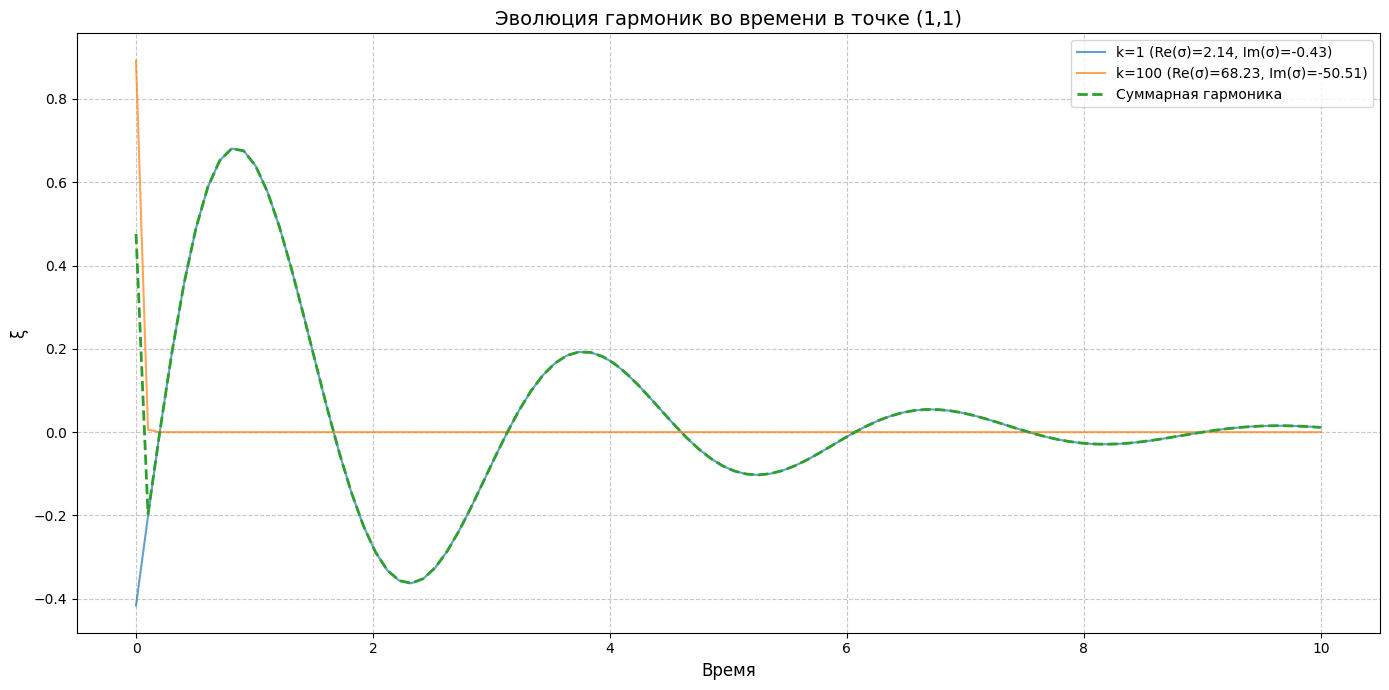

In [51]:
# Параметры для построения гармоники
A_val = parameter_values[A]
l_val = parameter_values[l]
x_point = 1
y_point = 1

# Функция для поиска ближайшего значения в массиве
def find_nearest_idx(array, value):
    return np.argmin(np.abs(array - value))

# Извлекаем данные для параметра k
param_k_results = all_results_with_B[k]
param_values_k = np.array([res[0] for res in param_k_results])

# Находим индексы для k=1 и k=100
idx_k1 = find_nearest_idx(param_values_k, 1)
idx_k100 = find_nearest_idx(param_values_k, 100)

# Получаем корни
_, roots_k1 = param_k_results[idx_k1]
_, roots_k100 = param_k_results[idx_k100]

# Выбираем корни с максимальной действительной частью
sigma_k1 = max(roots_k1, key=lambda x: x.real)
sigma_k100 = max(roots_k100, key=lambda x: x.real)

# Разделяем действительную и мнимую части
def process_sigma(sigma):
    return sigma.real, sigma.imag

sigma_real_k1, sigma_imag_k1 = process_sigma(sigma_k1)
sigma_real_k100, sigma_imag_k100 = process_sigma(sigma_k100)

print(sigma_real_k1, sigma_imag_k1)
print(sigma_real_k100, sigma_imag_k100)
print(idx_k1, idx_k100)

# Временной диапазон
t = np.linspace(0, 10, 100)

# Вычисляем гармоники
term1 = A_val * np.exp(sigma_imag_k1 * t) * np.cos(1 * x_point + l_val * y_point - sigma_real_k1 * t)
term2 = A_val * np.exp(sigma_imag_k100 * t) * np.cos(100 * x_point + l_val * y_point - sigma_real_k100 * t)
ksi_total = term1 + term2

# Построение графиков
plt.figure(figsize=(14, 7))
plt.plot(t, term1, label=f'k=1 (Re(σ)={sigma_real_k1:.2f}, Im(σ)={sigma_imag_k1:.2f})', alpha=0.7)
plt.plot(t, term2, label=f'k=100 (Re(σ)={sigma_real_k100:.2f}, Im(σ)={sigma_imag_k100:.2f})', alpha=0.7)
plt.plot(t, ksi_total, label='Суммарная гармоника', linestyle='--', linewidth=2)
plt.xlabel('Время', fontsize=12)
plt.ylabel('ξ', fontsize=12)
plt.title('Эволюция гармоник во времени в точке (1,1)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[0 1 2]
[0 1 2]
[(-2.14183+0.426837j), (1.68963+1.22417j), (0.747734-1.87066j), (-0.749118+1.86817j), (-0.0717924-3.41478j), (2.14158-0.430354j), (-1.68885-1.22759j), (0.0726513+3.40421j)]
[(-2.14183+0.426837j), (1.68963+1.22417j), (0.747734-1.87066j), (-0.749118+1.86817j), (-0.0717924-3.41478j), (2.14158-0.430354j), (-1.68885-1.22759j), (0.0726513+3.40421j)]


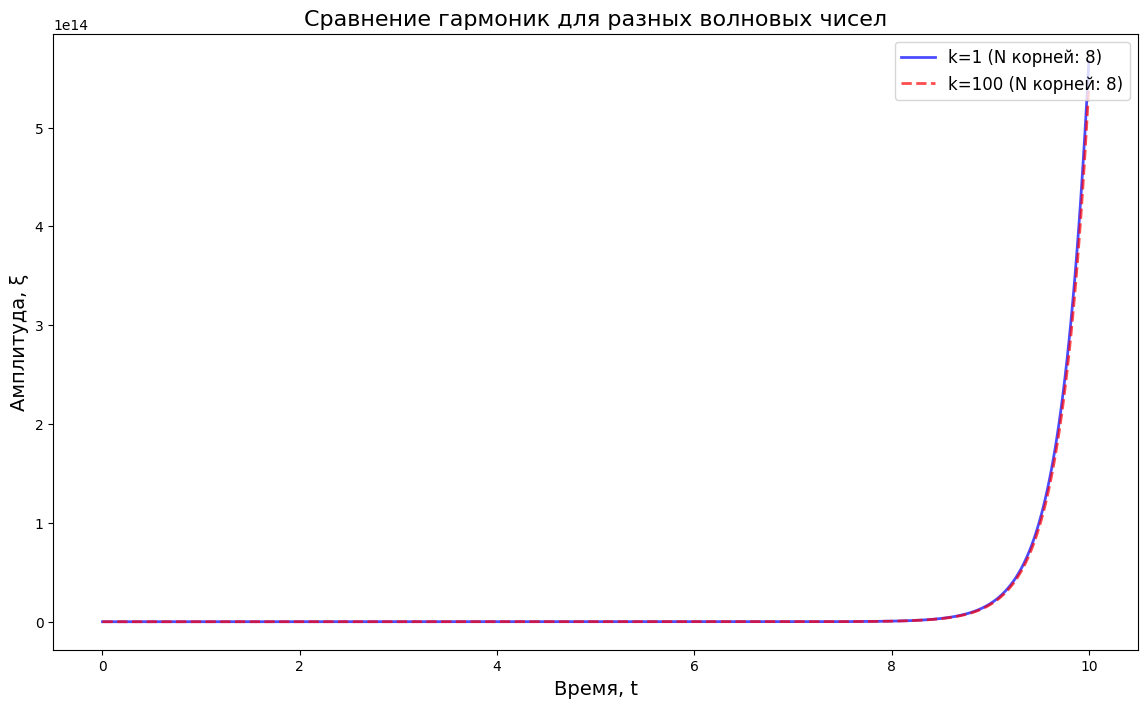

In [52]:
# Параметры для построения гармоник
A_val = parameter_values[A]
l_val = parameter_values[l]
x_point = 1
y_point = 1

def compute_harmonics(k_val, roots, t_range):
    """Вычисляет сумму гармоник для конкретного k и всех его корней"""
    ksi = np.zeros_like(t_range, dtype=np.float64)
    for sigma in roots:
        sigma_real = sigma.real  # σ₂ (экспоненциальный рост/затухание)
        sigma_imag = sigma.imag  # σ₁ (частота колебаний)

        # Вычисляем вклад каждой гармоники
        term = A_val * np.exp(sigma_imag * t_range) * \
               np.cos(k_val * x_point + l_val * y_point - sigma_real * t_range)
        ksi += term
    return ksi

# Извлекаем данные для k
param_k_results = all_results_with_B[k]
param_values_k = np.array([res[0] for res in param_k_results])

# Находим точные индексы (добавлена проверка)
def get_exact_idx(array, value, tol=10):
    idx = np.where(np.abs(array - value) < tol)[0]
    print(idx)
    return idx[0] if len(idx) > 0 else None

idx_k1 = get_exact_idx(param_values_k, 0.1)
idx_k100 = get_exact_idx(param_values_k, 0.2)

if idx_k1 is None or idx_k100 is None:
    raise ValueError("k=1 или k=100 не найдены в параметрах!")

# Получаем ВСЕ корни для k=1 и k=100
_, roots_k1 = param_k_results[idx_k1]
_, roots_k100 = param_k_results[idx_k100]

print(roots_k1)
print(roots_k100)

# Временной диапазон (увеличено количество точек для гладкости)
t = np.linspace(0, 10, 500)

# Вычисляем суммы гармоник для каждого k
ksi_k1 = compute_harmonics(0.1, roots_k1, t)
ksi_k100 = compute_harmonics(0.2, roots_k100, t)

# Построение графиков
plt.figure(figsize=(14, 8))

# График для k=1
plt.plot(t, ksi_k1,
         label=f'k=1 (N корней: {len(roots_k1)})',
         color='blue',
         alpha=0.7,
         linewidth=2)

# График для k=100
plt.plot(t, ksi_k100,
         label=f'k=100 (N корней: {len(roots_k100)})',
         color='red',
         alpha=0.7,
         linewidth=2,
         linestyle='--')

plt.xlabel('Время, t', fontsize=14)
plt.ylabel('Амплитуда, ξ', fontsize=14)
plt
plt.title('Сравнение гармоник для разных волновых чисел', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.show()